In [1]:
%cd ..\src
!python setup.py develop

c:\Users\mscer\dev\EchoVPR\src
running develop
running egg_info
writing echovpr.egg-info\PKG-INFO
writing dependency_links to echovpr.egg-info\dependency_links.txt
writing top-level names to echovpr.egg-info\top_level.txt
reading manifest file 'echovpr.egg-info\SOURCES.txt'
writing manifest file 'echovpr.egg-info\SOURCES.txt'
running build_ext
Creating c:\users\mscer\anaconda3\envs\patchnetvlad\lib\site-packages\echovpr.egg-link (link to .)
echovpr 1.0 is already the active version in easy-install.pth

Installed c:\users\mscer\dev\echovpr\src
Processing dependencies for echovpr==1.0
Finished processing dependencies for echovpr==1.0


C:\Users\mscer\anaconda3\envs\patchnetvlad\lib\site-packages\setuptools\command\easy_install.py:156: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
C:\Users\mscer\anaconda3\envs\patchnetvlad\lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(


In [2]:
from os.path import isfile, join

import wandb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
import numpy as np

from configs.utils import get_config, get_bool_from_config
from echovpr.datasets.utils import get_dataset, get_subset_dataset
from echovpr.models.utils import get_sparsity
from echovpr.models.single_esn import SingleESN
from echovpr.models.sparce_layer import SpaRCe

import logging

logging.basicConfig(level=logging.INFO)

In [3]:
config = get_config("configs\\train_esn_nordland_full_sweep.ini", log=False)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
artifact_name = 'uos_ml/echovpr/esn_4wkrv7z1:v0'

In [6]:
run = wandb.init()
artifact = run.use_artifact(artifact_name, type='model')
artifact_dir = artifact.download()

model_file = join(artifact_dir, 'model.pt')
esn_model_file = join(artifact_dir, 'esn_model.pt')

all_in_one = not isfile(esn_model_file)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mscerri (use `wandb login --relogin` to force relogin)


wandb: Downloading large artifact esn_4wkrv7z1:v0, 1101.55MB. 1 files... Done. 0:0:0


In [7]:
in_features=int(config['model_in_features'])
reservoir_size=int(config['model_reservoir_size'])
out_features=int(config['model_out_features'])

esn_alpha = float(config['model_esn_alpha'])
esn_gamma = float(config['model_esn_gamma'])
esn_rho = float(config['model_esn_rho'])
esn_num_connections = int(config['model_esn_num_connections'])
sparce_enabled = get_bool_from_config(config, 'model_sparce_enabled')

model = nn.ModuleDict()

esn_model = SingleESN(
  in_features, 
  reservoir_size, 
  alpha=esn_alpha, 
  gamma=esn_gamma, 
  rho=esn_rho,
  sparsity=get_sparsity(esn_num_connections, reservoir_size),
  device=device
)

if all_in_one:
  model["esn"] = esn_model

if sparce_enabled:
  model["sparce"] = SpaRCe(reservoir_size)

model["out"] = nn.Linear(in_features=reservoir_size, out_features=out_features, bias=True)

In [8]:
if not all_in_one:
  esn_model.load_state_dict(torch.load(esn_model_file))

model.load_state_dict(torch.load(model_file))

<All keys matched successfully>

In [9]:
if not all_in_one:
  esn_model.eval().to(device)
  
model.eval().to(device)

ModuleDict(
  (esn): SingleESN(in_features=500, out_features=8000)
  (out): Linear(in_features=8000, out_features=27592, bias=True)
)

In [10]:
summer_dataset = get_dataset(config['dataset_nordland_summer_hidden_repr_file_path'])
winter_dataset = get_dataset(config['dataset_nordland_winter_hidden_repr_file_path'])

max_n = summer_dataset.tensors[0].max()
_ = summer_dataset.tensors[0].divide_(max_n)
_ = winter_dataset.tensors[0].divide_(max_n)

In [11]:
def process(model, dataLoader, device: torch.device):
    x_processed_list = []
    y_target_list = []
    
    for x, y_target in dataLoader:
        x = x.to(device)
        x_processed = model(x)

        x_processed_list.append(x_processed.cpu())
        y_target_list.append(y_target)

    return (torch.vstack(x_processed_list), torch.vstack(y_target_list))

In [12]:
print(f"Winter dataset size: {len(winter_dataset)}")
winter_dataLoader = DataLoader(winter_dataset, num_workers=int(config['dataloader_threads']), batch_size=int(config['train_batchsize']), shuffle=False)

Winter dataset size: 27592


In [13]:
winter_dataset = TensorDataset(*process(esn_model, winter_dataLoader, device))
dataset_size = len(winter_dataset)

In [14]:
dataLoader = DataLoader(winter_dataset, num_workers=int(config['dataloader_threads']), batch_size=int(config['train_batchsize']), shuffle=False)

In [15]:
val_dataset_quantiles = None

if sparce_enabled:
    # Calculate Training Dataset Quantiles
    quantile = float(config['model_sparce_quantile'])
    winter_dataset_quantiles = torch.quantile(torch.abs(torch.vstack([t[0] for t in winter_dataset])), quantile, dim=0).to(device)

In [16]:
def get_predictions(model, dataLoader, sparce_enabled, quantiles):
    predictions = []
    ground_truths = []

    with torch.no_grad():    
        for x, y_target in dataLoader:

            x = x.to(device)
            
            if sparce_enabled:
                x = model["sparce"](x, quantiles)

            preds = model["out"](x)

            predictions.append(preds.cpu())
            ground_truths.append(y_target)

    return (torch.vstack(predictions), torch.vstack(ground_truths))

In [17]:
preds = TensorDataset(*get_predictions(model, dataLoader, sparce_enabled, val_dataset_quantiles))

In [18]:
y_score = preds.tensors[0].numpy()
y_test = preds.tensors[1].numpy()

In [19]:
n_classes = 27592

In [20]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
# import warnings
# warnings.filterwarnings("ignore")

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")

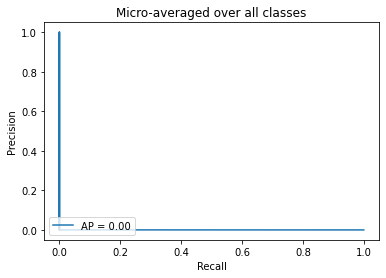

In [21]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

In [22]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_score, name="LinearSVC")
_ = display.ax_.set_title("2-class Precision-Recall curve")

ValueError: multilabel-indicator format is not supported